# Load Synth Data

In [33]:
import pandas as pd
import torch, transformer_lens, itertools, tqdm
from functools import partial

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import seaborn as sns
import numpy as np

tqdm.tqdm.pandas()

from measureLM import helpers

## Load Data

In [13]:
df = pd.read_excel(helpers.ROOT_DIR / "data" / "friend_enemy_list.xlsx")
df

,ent1,ent2,label,type
0,Sherlock Holmes,James Moriarty,enemy,movie
1,Obi Wan Kenobi,Darth Maul,enemy,movie
2,Harry Potter,Lord Voldemort,enemy,movie
3,Harry Potter,Draco Malfoy,enemy,movie
4,Spiderman,Norman Osborne,enemy,movie
...,...,...,...,...
68,Bill Gates,Paul Allen,friend,business
69,Larry Page,Sergei Brin,friend,business
70,Mike Wazowski,James P. Sullivan,friend,movie
71,Sherlock Holmes,John Watson,friend,movie


## Analyse

In [14]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small").to("cpu")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


In [34]:
class Default(dict):
    def __missing__(self, key):
        return '{' + key + '}'

    
def select_logits(logits, scale): 
    #token = model.cfg.spacing + token
    #token_id = model.tokenizer.convert_tokens_to_ids(token)
    indices = torch.LongTensor([model.tokenizer.encode(f" {token}")[0] for token in scale])
    logits = torch.index_select(logits[...,-1,:], -1, indices)
    logits_normed = logits / logits.sum()
    return logits_normed[...,0].item() 


def apply_scales(logits, scales):
    scale_vals, scale_name  = [],[]
    for scale in scales:
        value = select_logits(logits, scale)
        scale_vals.append(value)
        scale_name.append("_".join(scale))
    return torch.tensor(scale_vals), scale_name


def compute_measurement(kwargs, prompt, model, scales):
    
    prompt = prompt.format_map(Default(kwargs))
    logits, activs = model.run_with_cache(prompt)
    scale_vals_forward, scale_name = apply_scales(logits, scales)

    kwargs['ent1'], kwargs['ent2'] = kwargs['ent2'], kwargs['ent1']
    prompt = prompt.format_map(Default(kwargs))
    logits, activs = model.run_with_cache(prompt)
    scale_vals_backward, scale_name = apply_scales(logits, scales)
    
    scale_vals = (scale_vals_forward + scale_vals_backward) / 2
    return scale_vals.tolist()  
    


In [35]:

scales = [["good", "bad"], ["friendly", "hostile"],["positive", "negative"]]
prompt = "The relationship between {ent1} and {ent2} is"

scale_names = ["-".join(scale) for scale in scales]
df[scale_names] = df.progress_apply(lambda row: compute_measurement({"ent1": row["ent1"],"ent2": row["ent2"]}, prompt, model, scales), axis=1, result_type="expand")

df

100%|███████████████████████████████████████████| 73/73 [00:07<00:00,  9.74it/s]


,ent1,ent2,label,type,good bad,friendly hostile,positive negative,good-bad,friendly-hostile,positive-negative
0,Sherlock Holmes,James Moriarty,enemy,movie,0.510212,0.508598,0.533101,0.510212,0.508598,0.533101
1,Obi Wan Kenobi,Darth Maul,enemy,movie,0.518982,0.508959,0.533098,0.518982,0.508959,0.533098
2,Harry Potter,Lord Voldemort,enemy,movie,0.497713,0.492970,0.515376,0.497713,0.492970,0.515376
3,Harry Potter,Draco Malfoy,enemy,movie,0.504969,0.512883,0.524984,0.504969,0.512883,0.524984
4,Spiderman,Norman Osborne,enemy,movie,0.517571,0.535514,0.541340,0.517571,0.535514,0.541340
...,...,...,...,...,...,...,...,...,...,...
68,Bill Gates,Paul Allen,friend,business,0.518334,0.521488,0.538938,0.518334,0.521488,0.538938
69,Larry Page,Sergei Brin,friend,business,0.512406,0.525654,0.530362,0.512406,0.525654,0.530362
70,Mike Wazowski,James P. Sullivan,friend,movie,0.521455,0.517132,0.535659,0.521455,0.517132,0.535659
71,Sherlock Holmes,John Watson,friend,movie,0.517268,0.511310,0.539121,0.517268,0.511310,0.539121


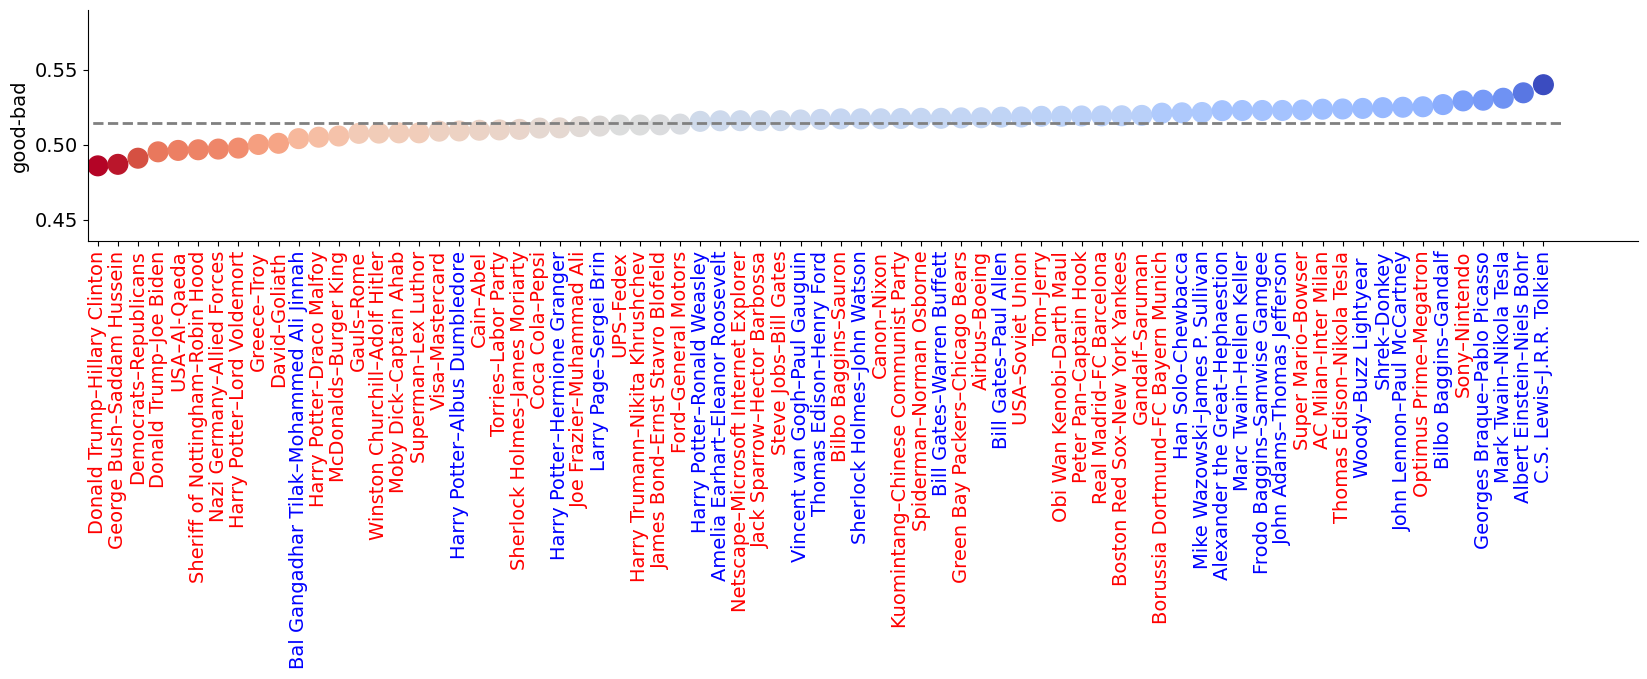

In [51]:
def visualize_measurment(df, scale_name = "good-bad", save=False):
    
    df = df.sort_values(scale_name)
    df = df.reset_index(drop=True)

    ent1, ent2, labels = df["ent1"].to_list(), df["ent2"].to_list(), df["label"].to_list()
    ent1_2 = [f"{e1}–{e2}" for e1, e2 in list(zip(ent1, ent2))]
    vals = df[scale_name].to_numpy()
    x_vals = np.arange(0, len(vals))
    
    # Draw plot
    titlefont = 20
    labelfont = 14

    fig, ax = plt.subplots(1, 1, figsize=(20, 3), gridspec_kw={'hspace': 0.4})
    ax.scatter(x_vals, vals, s=200, alpha=1.0, c=vals, cmap=cm.coolwarm_r)
    ax.hlines(y=vals.mean(), xmin=x_vals.min()-1, xmax=x_vals.max()+1, linewidth=2, linestyle= '--', color='grey')
    #for x, y in zip(x_vals, vals):
        #t = ax.text(x, y, round(y, 1), horizontalalignment='center', 
        #verticalalignment='center', fontdict={'color':'white'})

    ax.xaxis.set_ticks(x_vals)
    ax.tick_params(axis='both', which='major', labelsize=labelfont)
    ax.set_xticklabels(ent1_2, fontsize=labelfont, rotation=90)
    ax.set_ylim(vals.min() - 0.05, vals.max() + 0.05)
    ax.set_xlim(-0.5)
    #ax.set_title(scale_name, fontsize=titlefont, color="black", loc='center')
    ax.set_ylabel(scale_name, fontsize=labelfont)

    for i, x_tick_label in enumerate(ax.get_xticklabels()):
        label = labels[i] 
        if label == "enemy":
            color = "red"
        elif label == "friend":
            color = "blue"
        x_tick_label.set_color(color)
        
    if save:
        fig.savefig(helpers.ROOT_DIR / "results" / "plots" / "gpt-xl.pdf", bbox_inches='tight', dpi=200, transparent=True)
        
        
visualize_measurment(df, scale_name = "good-bad")